## Crypto Forecasting 

### Problem setting 

This is a kaggle competition by G-Research.[Link](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

Over $40 billion worth of cryptocurrencies are traded every day. They are among the most popular assets for speculation and investment, yet have proven wildly volatile. Fast-fluctuating prices have made millionaires of a lucky few, and delivered crushing losses to others.

Nonetheless being able to predict theses prices can help investors make money and maybe gain insight into the finicial crypto currency world.

This problem would be considered a time series regression problem where our target variable is coutinous representing 15 minute residualized returns from 14 popular cryptocurrencies

### EDA

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from datetime import datetime,timedelta
from pandas.plotting import lag_plot,autocorrelation_plot
from sklearn.decomposition import PCA
import sys
import gc 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import torch.nn as nn
from torchsummary import summary
from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
import random 
from ray.air import Checkpoint,session
random.seed(42)
np.random.seed(42)

In [3]:
df=pd.read_csv('crypto.csv')

In [4]:
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [5]:
df_assest=pd.read_csv('asset_details.csv')
df_assest

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [6]:
#adding asset name to help with visualizations
df['Asset_Name'] = df['Asset_ID'].map(df_assest.set_index('Asset_ID')['Asset_Name'])

In [7]:
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,Bitcoin Cash
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,Binance Coin
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,Bitcoin
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,EOS.IO
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,Ethereum Classic


### Meaning of variables 

> timestamp - A timestamp for the minute covered by the row.

>Asset_ID - An ID code for the cryptoasset. To decode which is which we also have another file assests.csv

>Count - The number of trades that took place this minute.

>Open - The USD price at the beginning of the minute.

>High - The highest USD price during the minute.

>Low - The lowest USD price during the minute.

>Close - The USD price at the end of the minute.

>Volume - The number of cryptoasset units traded during the minute.

>VWAP - The volume weighted average price for the minute.

>Target - 15 minute residualized returns

Quoting from the kaggle competition "
`Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Crypto asset returns are highly correlated, following to a large extend the overall crypto market. As we want to test your ability to predict returns for individual assets, we perform a linear residualization, removing the market signal from individual asset returns when creating the target. In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}  \\
\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle} \\
\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric."

In [8]:
#set index to be timestamp 
df.set_index("timestamp",inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26755084 entries, 1514764860 to 1642982400
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Asset_ID    int64  
 1   Count       float64
 2   Open        float64
 3   High        float64
 4   Low         float64
 5   Close       float64
 6   Volume      float64
 7   VWAP        float64
 8   Target      float64
 9   Asset_Name  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.2+ GB


In [10]:
#reduce dataframe instead of every minute to every 1 hour1
df_new = pd.DataFrame()
for asset in df.Asset_Name.unique():
    df_asset=df[df["Asset_Name"]==asset]
    df_asset=df_asset.iloc[::60, :]#every 60 almost equivalent to 1 hours 
    df_new=pd.concat([df_new,df_asset])#concat everything to recreate the dataframe
df=df_new
df.sort_index(inplace=True)#sort by timestamp again 
    

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445924 entries, 1514764860 to 1642981500
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Asset_ID    445924 non-null  int64  
 1   Count       445924 non-null  float64
 2   Open        445924 non-null  float64
 3   High        445924 non-null  float64
 4   Low         445924 non-null  float64
 5   Close       445924 non-null  float64
 6   Volume      445924 non-null  float64
 7   VWAP        445924 non-null  float64
 8   Target      433451 non-null  float64
 9   Asset_Name  445924 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 37.4+ MB


In [12]:
df.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,445924.000000,445924.000000,445924.000000,445924.000000,445924.000000,445924.000000,4.459240e+05,4.459240e+05,4.334510e+05
mean,6.311914,305.246286,1703.187793,1706.944790,1699.973873,1703.190061,2.936162e+05,inf,-6.168263e-07
std,4.086631,895.635412,7137.094312,7146.923598,7127.412444,7137.144015,2.443814e+06,NaN,5.513959e-03
min,0.000000,1.000000,0.001275,0.001300,0.001270,0.001294,1.400000e-07,-2.548139e+02,-2.452924e-01
25%,3.000000,21.000000,0.282843,0.283700,0.281900,0.282800,1.401295e+02,2.827911e-01,-1.642355e-03
50%,6.000000,72.000000,15.390763,15.408600,15.372350,15.389050,1.288659e+03,1.538982e+01,-4.129166e-05
75%,10.000000,248.000000,247.562342,248.192500,246.972500,247.580833,3.035195e+04,2.475605e+02,1.556067e-03
max,13.000000,165016.000000,68610.326667,68741.900000,68580.931391,68666.145714,4.165365e+08,inf,2.727561e-01


In [13]:
#check for missing values
df.isnull().sum()

Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              0
Target        12473
Asset_Name        0
dtype: int64

In [14]:
np.isinf(df.VWAP).sum()

1

In [15]:
#add date 
df["datetime"] = pd.to_datetime(df.index,unit='s')

In [16]:
df.Asset_Name.unique()

array(['Bitcoin Cash', 'Ethereum Classic', 'Ethereum', 'Bitcoin',
       'Litecoin', 'Monero', 'Binance Coin', 'EOS.IO', 'TRON', 'Stellar',
       'Cardano', 'IOTA', 'Maker', 'Dogecoin'], dtype=object)

In [17]:
# check for time period for all of the data 
start_date=(df.datetime.min())
end_date=(df.datetime.max())
print('Data ranges is from {} till {}'.format(start_date,end_date))

Data ranges is from 2018-01-01 00:01:00 till 2022-01-23 23:45:00


In [18]:
#check time period for each asset
df.groupby('Asset_Name').datetime.min()

Asset_Name
Binance Coin       2018-01-01 00:01:00
Bitcoin            2018-01-01 00:01:00
Bitcoin Cash       2018-01-01 00:01:00
Cardano            2018-04-17 09:11:00
Dogecoin           2019-04-12 14:34:00
EOS.IO             2018-01-01 00:01:00
Ethereum           2018-01-01 00:01:00
Ethereum Classic   2018-01-01 00:01:00
IOTA               2018-05-09 08:07:00
Litecoin           2018-01-01 00:01:00
Maker              2018-05-10 15:21:00
Monero             2018-01-01 00:01:00
Stellar            2018-02-16 23:53:00
TRON               2018-02-06 21:37:00
Name: datetime, dtype: datetime64[ns]

In [19]:
df.groupby('Asset_Name').datetime.max()

Asset_Name
Binance Coin       2022-01-23 23:22:00
Bitcoin            2022-01-23 23:23:00
Bitcoin Cash       2022-01-23 23:23:00
Cardano            2022-01-23 23:44:00
Dogecoin           2022-01-23 23:29:00
EOS.IO             2022-01-23 23:27:00
Ethereum           2022-01-23 23:45:00
Ethereum Classic   2022-01-23 23:23:00
IOTA               2022-01-23 23:01:00
Litecoin           2022-01-23 23:36:00
Maker              2022-01-23 23:42:00
Monero             2022-01-23 23:08:00
Stellar            2022-01-23 23:20:00
TRON               2022-01-23 23:27:00
Name: datetime, dtype: datetime64[ns]

> Different time periods for different assets 

In [20]:
#check if it is sorted according to time 
df.index.is_monotonic

True

In [21]:
#check gaps between timestamp for each assest
for asset in df.Asset_Name.unique():
    df_asset=df[df["Asset_Name"]==asset]
    print(asset,'gap counts are ')
    print((df_asset.index[1:]-df_asset.index[:-1]).value_counts().head())

Bitcoin Cash gap counts are 
3600    34438
3660      596
3720      214
3780      121
3840       75
Name: timestamp, dtype: int64
Ethereum Classic gap counts are 
3600    33056
3660     1506
3720      462
3780      186
3840       94
Name: timestamp, dtype: int64
Ethereum gap counts are 
3600    35535
3660       52
3780        2
3720        2
4140        2
Name: timestamp, dtype: int64
Bitcoin gap counts are 
3600     35541
3660        49
5580         2
6420         1
17280        1
Name: timestamp, dtype: int64
Litecoin gap counts are 
3600    35491
3660       91
3780        3
4500        1
3900        1
Name: timestamp, dtype: int64
Monero gap counts are 
3600    17064
3660     2074
3720     1292
3780      950
3840      877
Name: timestamp, dtype: int64
Binance Coin gap counts are 
3600    32218
3660     1641
3720      690
3780      289
3840      191
Name: timestamp, dtype: int64
EOS.IO gap counts are 
3600    35110
3660      228
3720       98
3780       45
3840       29
Name: timestam

> almost all gaps are very close to the one hour interval

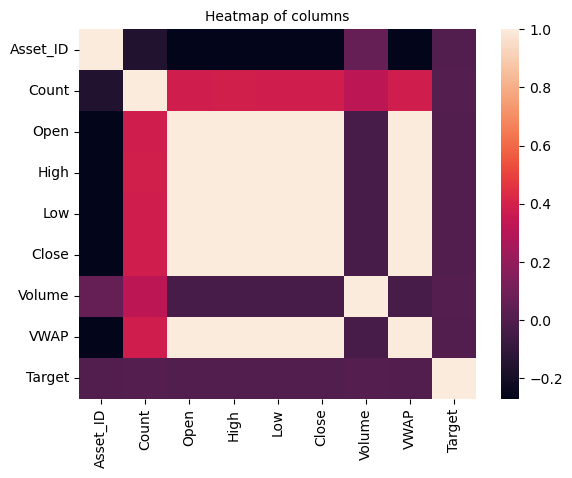

In [22]:
#check for linear correlation between columns 
sns.heatmap(df.corr());
plt.title('Heatmap of columns', fontsize = 10);

In [23]:
#check for linear correlation between targets of different currencies
data = df[['datetime', 'Asset_Name', 'Target']]
#Creating dataframe with a column for each different Assest ID
data_new = data.set_index(['datetime', 'Asset_Name']).unstack(['Asset_Name'])
#remove vwap from column index
data_new.columns=data_new.columns.droplevel(0)

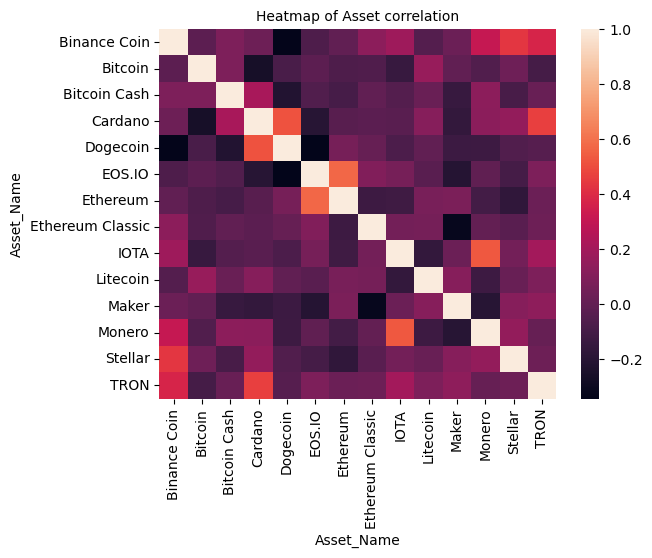

In [24]:
#check for linear correlation between targets of different currencies
sns.heatmap(data_new.corr());
plt.title('Heatmap of Asset correlation', fontsize = 10);

In [25]:
#check for linear correlation for close price
data = df[['datetime', 'Asset_Name', 'Close']]
#Creating dataframe with column for each different Assest ID
data_new = data.set_index(['datetime', 'Asset_Name']).unstack(['Asset_Name'])
#remove vwap from column index
data_new.columns=data_new.columns.droplevel(0)

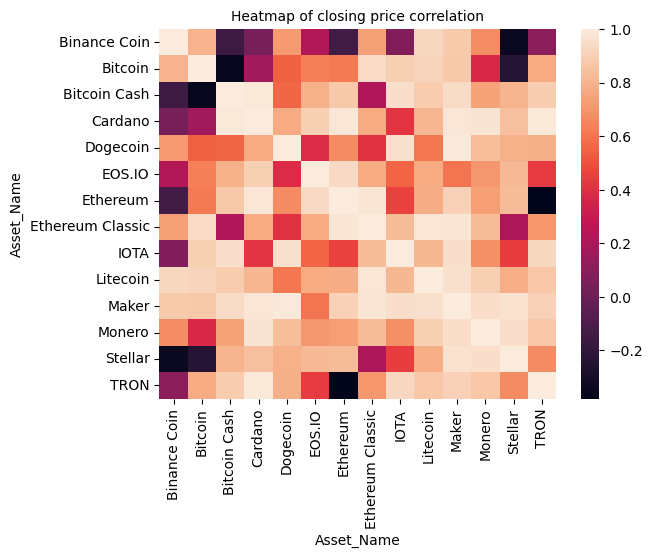

In [26]:
#check for linear correlation for close price
sns.heatmap(data_new.corr());
plt.title('Heatmap of closing price correlation', fontsize = 10);

> We can see a linear correlation between close prices however not between targets as target is a log transformed and normalized value I would be surprised to see the linear relationship still existing 

In [27]:
#just to see the data
def plot_Target(df,assets):
    fig, ax = plt.subplots()
    for asset in assets:
        ax.plot('datetime', 'Target', data=df[df["Asset_Name"]==asset],label=asset)

    ax.set_title('Time Plot of Target');
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.xticks(rotation=90);

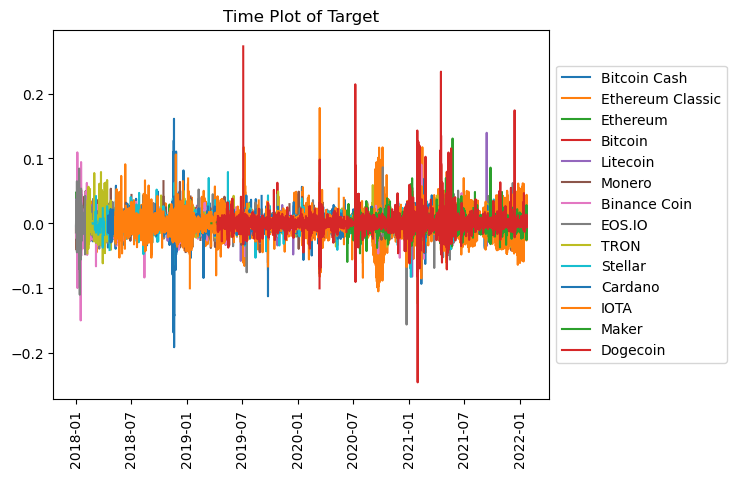

In [28]:
plot_Target(df,df.Asset_Name.unique())

> The target variable looks really messy and centered around 0 with not much variation 

In [29]:
#just to see the data
def plot_close(df,assets):
    fig, ax = plt.subplots()
    for asset in assets:
        ax.plot('datetime', 'Close', data=df[df["Asset_Name"]==asset],label=asset)

    ax.set_title('Time Plot of close price');
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.xticks(rotation=90);

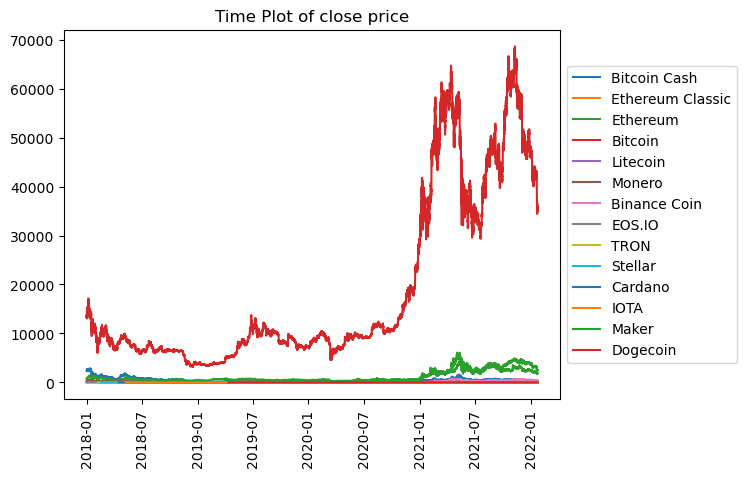

In [30]:
plot_close(df,df.Asset_Name.unique())

> The Bitcoin close is domintant as it has much higher values

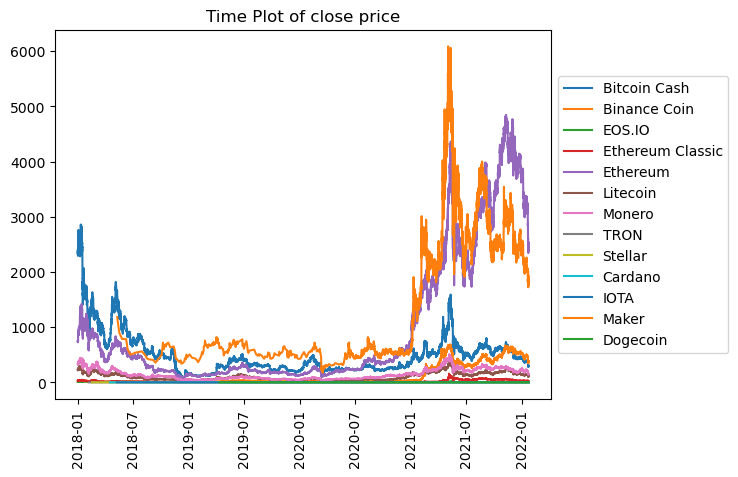

In [31]:
#let's plot again without bitcoin
plot_close(df,['Bitcoin Cash', 'Binance Coin', 'EOS.IO','Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON','Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin'])

> We can see that they seem to be somehow following the same path

>As we already saw from the heatmap the prices at close time do look quite correlated so in our following analsyis we will focus on Bitcoin and Etheruim 

> Stationary time series are easier to model and to predict so it is worth it to check for stationarity here.
For data to be stationary, the statistical properties of a system do not change over time.



In [32]:
#To double check stationarty time series 
def check_stationary(asset,df,window):
    
    min_periods=int(window/2)
    moving_average = df[df["Asset_Name"]==asset]['Target'].rolling(
        window=window,       # 1week window
        center=True,      # puts the average at the center of the window
        min_periods=min_periods,  # choose about half the window size
    ).mean()
    moving_std=df[df["Asset_Name"]==asset]['Target'].rolling(
        window=window,       # 1week window
        center=True,      # puts the average at the center of the window
        min_periods=min_periods,  # choose about half the window size
    ).std()
    fig, ax = plt.subplots()
    ax.plot('datetime', 'Target', data=df[df["Asset_Name"]==asset], color='red',label='Target');
    ax.plot(df[df["Asset_Name"]==asset]['datetime'], moving_average, color='black',label='Target mean');
    ax.plot(df[df["Asset_Name"]==asset]['datetime'], moving_std, color='blue',label='Target std');
    ax.set_ylim([-1, 1]);
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.xticks(rotation=90);

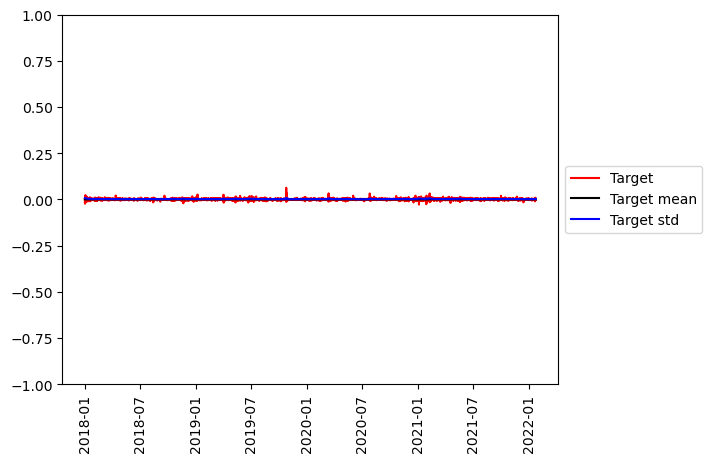

In [33]:
#window of one week 
#We plot a moving average of one week against the target signal
check_stationary('Bitcoin',df,168)

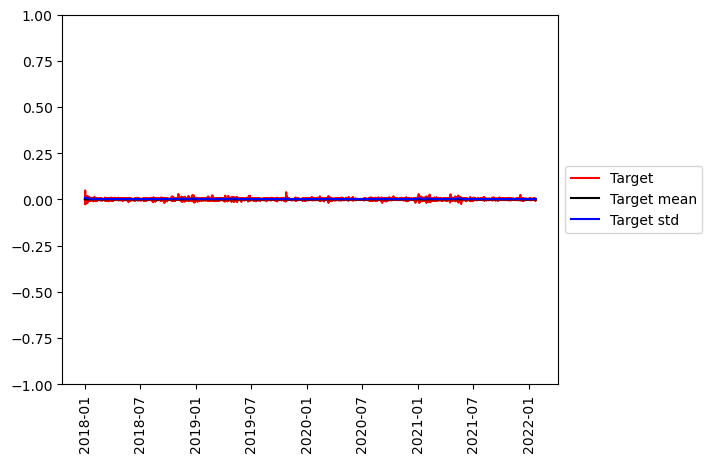

In [34]:
check_stationary('Ethereum',df,168)

>The target looks very stationary due to the transformations done in's calcualtion which make sense however it could simply imply being white noise without any patterns.

> We can check for autocorrelation with previous observations in the last week to check if we have white noise which is defined as mean=0 ,std=0 and 0 correlation between observations

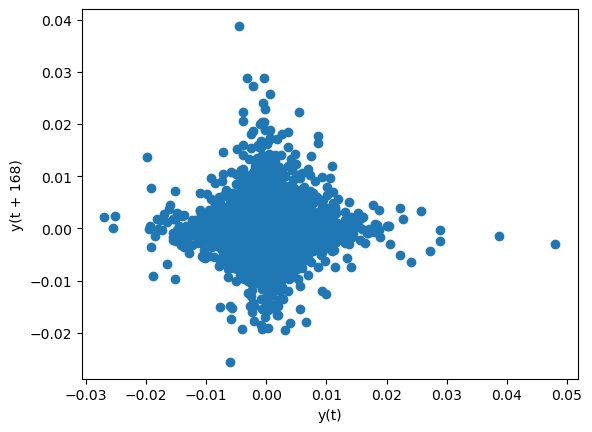

In [35]:
#Plot of target against itself lagged by 168 steps (one week)
lag_plot(df[df["Asset_Name"]=='Ethereum']['Target'],lag=168);

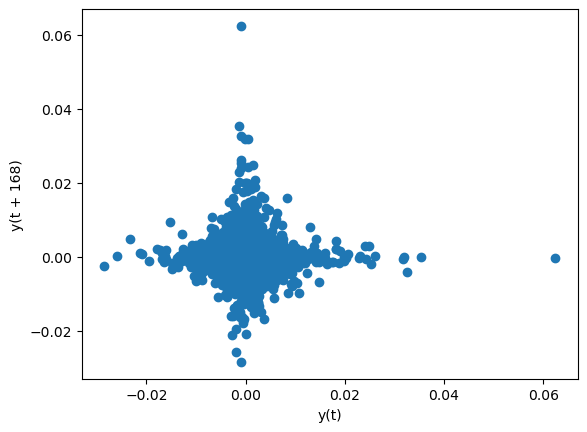

In [36]:
lag_plot(df[df["Asset_Name"]=='Bitcoin']['Target'],lag=168);

> The lag plots shows a star shaped relation ship between the target variables and one week lag variables we will attempt to model this function 

In [37]:
#Quick visualization of the variables per asset
def quick_visualize(df,asset):
    fig, axs = plt.subplots(3, 2)
    axs[0, 0].plot('datetime', 'Open', data=df[df["Asset_Name"]==asset])
    axs[0, 0].set_title('Time Plot of open price for {}'.format(asset));
    axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[0, 0].tick_params(axis='x', rotation=90)
    axs[0, 1].plot('datetime', 'High', data=df[df["Asset_Name"]==asset])
    axs[0, 1].set_title('Time Plot of High price for {}'.format(asset));
    axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[0, 1].tick_params(axis='x', rotation=90)
    axs[1, 0].plot('datetime', 'Low', data=df[df["Asset_Name"]==asset])
    axs[1, 0].set_title('Time Plot of Low price for {}'.format(asset));
    axs[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[1, 0].tick_params(axis='x', rotation=90)
    axs[1, 1].plot('datetime', 'VWAP', data=df[df["Asset_Name"]==asset])
    axs[1, 1].set_title('Time Plot of VWAP price for {}'.format(asset));
    axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[1, 1].tick_params(axis='x', rotation=90)
    axs[2, 1].plot('datetime', 'Close', data=df[df["Asset_Name"]==asset])
    axs[2, 1].set_title('Time Plot of Close price for {}'.format(asset));
    axs[2, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[2, 1].tick_params(axis='x', rotation=90)
    axs[2, 0].plot('datetime', 'Target', data=df[df["Asset_Name"]==asset])
    axs[2, 0].set_title('Time Plot of Target {}'.format(asset));
    axs[2, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    axs[2, 0].tick_params(axis='x', rotation=90)
    fig.tight_layout()

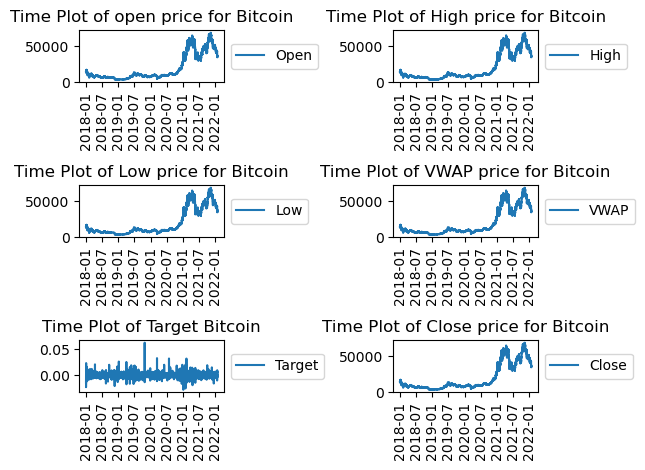

In [38]:
quick_visualize(df,'Bitcoin')

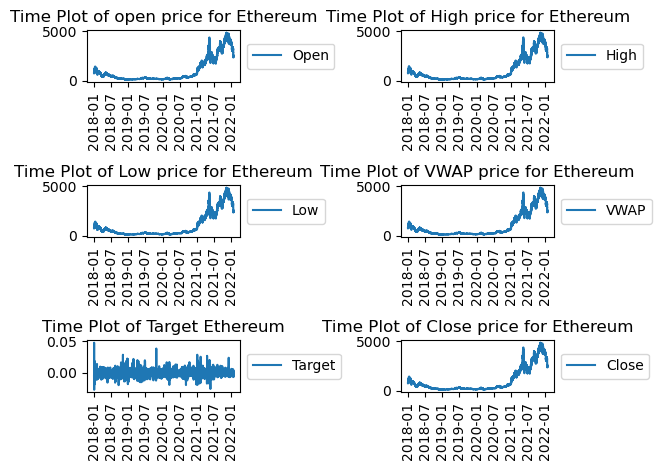

In [39]:
quick_visualize(df,'Ethereum')

> We can see that the features of both currencies here are somehow are in aggreenment 

>I will also visualize a shorter version of the time series for only the last 3 months of data to also see recent trends and if they differ from the long term.

In [40]:
df_reduced=df[df['datetime']>df.datetime.iloc[-1]-timedelta(days=90)]

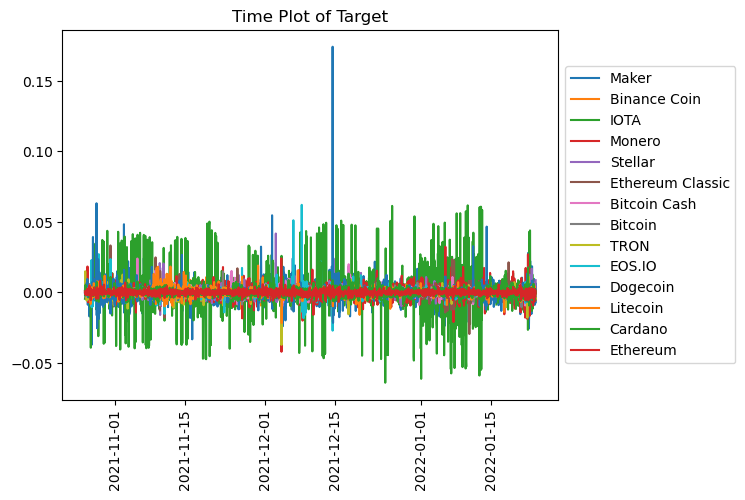

In [41]:
plot_Target(df_reduced,df_reduced.Asset_Name.unique())

> As messy as the full dataset 

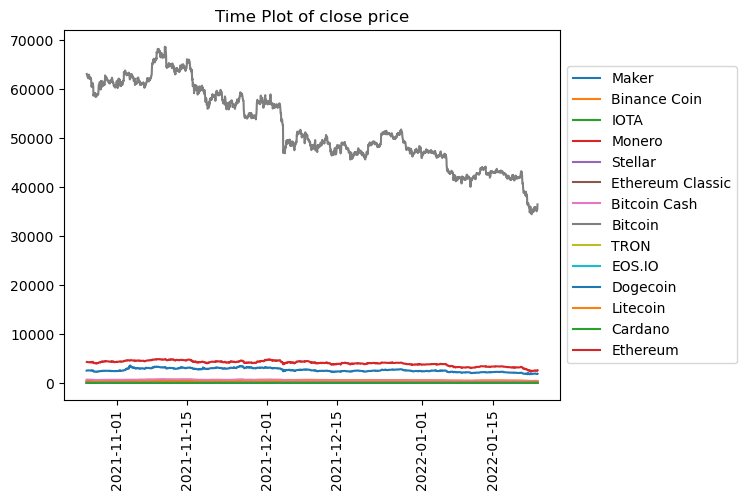

In [42]:
#just to see the data
plot_close(df_reduced,df_reduced.Asset_Name.unique())

> Difference to full dataset  is that the currencies seem to be going down but bitcoin remains dominant 

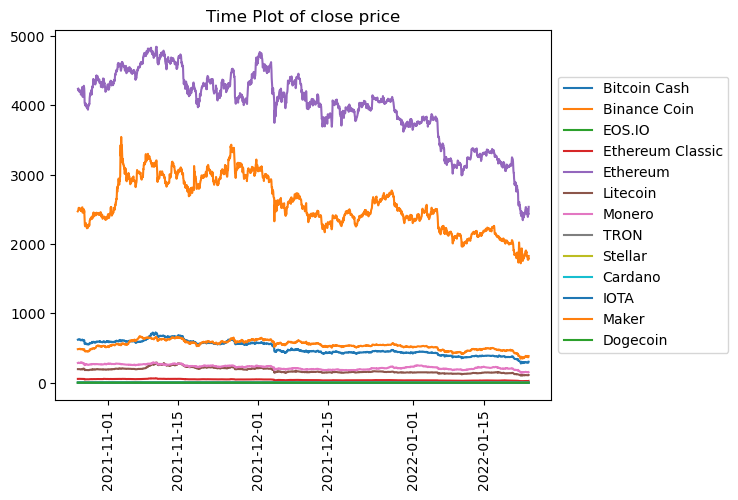

In [43]:
#let's plot again without bitcoin
plot_close(df_reduced,['Bitcoin Cash', 'Binance Coin', 'EOS.IO','Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON','Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin'])

> Difference to full dataset is that the currencies seem to be going down, however they still look quite correlated

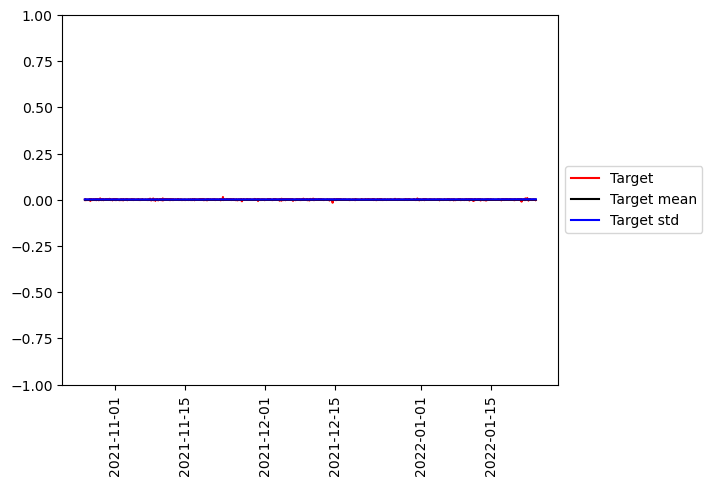

In [44]:
check_stationary('Bitcoin',df_reduced,168)

> Stationary as well

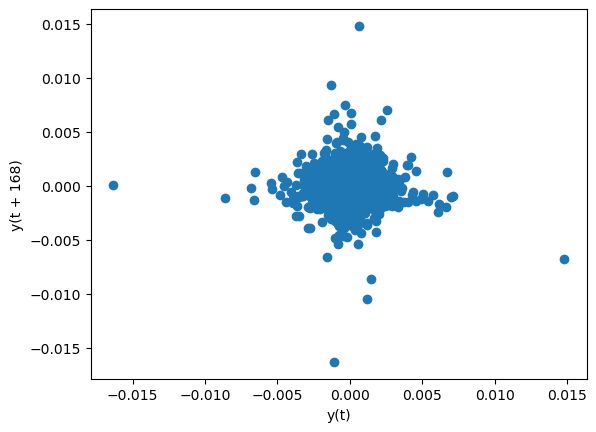

In [45]:
lag_plot(df_reduced[df_reduced["Asset_Name"]=='Bitcoin']['Target'],lag=168);

> Same lag pattern

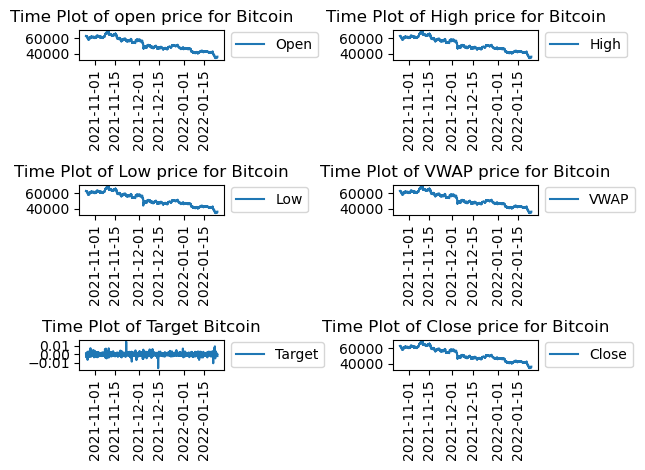

In [46]:
quick_visualize(df_reduced,'Bitcoin')

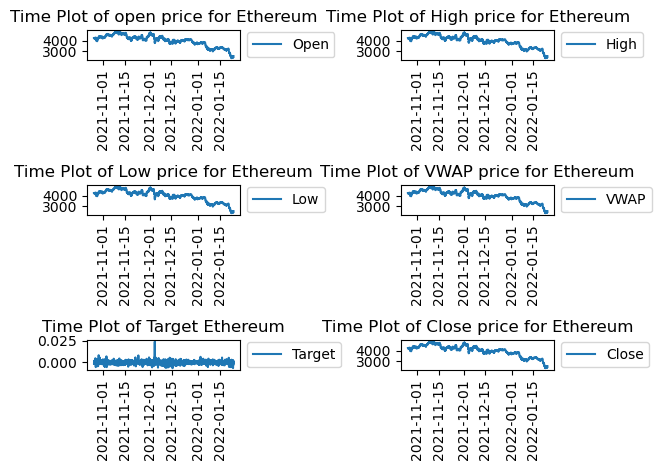

In [47]:
quick_visualize(df_reduced,'Ethereum')

> Same as full dataset except that prices are decreasing 

### Feature Engineering 

> I will construct some features which could help our predication of the target variable.

 > Firstly I will need to split the dataframe into dataframes of the same asset to ensure that the features are valid and then do the same transformation on each indivdual dataframe and in the end concat the results again.
 
 > There are 7 infinty values are replace with nans that are then filled later 
 
 >  I will construct log returns of the Close, open , high , low , and vwap columns The  justification for this since the target variable is sort of a log return plus log reutrns and since logarithmic returns are additive over time unlike simple returns.  
 
 >  I will construct an expotentially weigthed mean series varaiable for the Close, open , high , low , and vwap columns to give higher weights to closer observations.  
 
 >  Next I will constrcut a lag variable for the Close, open , high , low ,target and vwap columns as feeding in lag variables can sometimes help with time series prediction.  
 

 

 > Since the time gaps are not consistent even though most of them are 1 hour apart I will use the last observation to fill in for the gaps.
 
 > Next I will fill the na values with the last valid observation since na values are a small percentage of the total and then in case the first value is nan I will use back filling afterwards to ensure no nans anywhere.
 
 > Finally I will scale all input variables to be in the range of 0 and 1 using max - min normalization which is basically X_scaled = (X-X_min)/(X_max-X)

In [48]:
# define function to compute log returns https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/
def log_return(series, periods=15):
    return np.log(series).diff(periods=periods)

In [49]:
df_new = pd.DataFrame()
scaler = preprocessing.MinMaxScaler()
cols=['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
           'Close_log', 'Open_log', 'High_log','Low_log', 'VWAP_log',
           'Close_ewp', 'Open_ewp', 'High_ewp', 'Low_ewp',
           'VWAP_ewp', 'Close_lag', 'Open_lag', 'High_lag', 
          'Low_lag', 'VWAP_lag','Target_lag']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
#we have to do the transformation per asset 
for asset in df.Asset_Name.unique():
    df_asset=df[df["Asset_Name"]==asset]
    #calculate log return
    df_asset[['Close_log','Open_log',
    'High_log','Low_log','VWAP_log']] = (df_asset[['Close','Open','High','Low','VWAP']].apply(log_return))
    #calculate expontential weighted series
    df_asset[['Close_ewp','Open_ewp',
    'High_ewp','Low_ewp','VWAP_ewp']] = (df_asset[['Close','Open','High','Low','VWAP']].ewm(alpha=1/15).mean())
    #introduce lag variables
    df_asset[['Close_lag','Open_lag',
    'High_lag','Low_lag','VWAP_lag','Target_lag']]  = df_asset[['Close','Open','High','Low','VWAP','Target']].shift(15)
    #forward padding for each missing X interval
    df_asset = df_asset.reindex(range(df_asset.index[0],df_asset.index[-1]+3600,3600),method='pad')
    
    df_asset.fillna(method="ffill",inplace=True)#filling values that are nans 
    df_asset.fillna(method='bfill',inplace=True)#if first value is missing we drop it
    
    df_asset[cols] = scaler.fit_transform(df_asset[cols])
    df_new=pd.concat([df_new,df_asset])#concat everything to recreate the dataframe
df=df_new
df.sort_index(inplace=True)#sort by timestamp again 
df["datetime"] = pd.to_datetime(df.index,unit='s')#create matching datetime again 

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset[['Close_log','Open_log',
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3488916155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [100]:
#confirm no nulls
df.isnull().sum().any()

False

In [51]:
#check that gaps are all apart x hours now 
for asset in df.Asset_Name.unique():
    df_asset=df[df["Asset_Name"]==asset]
    print(asset,'Gaps')
    print((df_asset.index[1:]-df_asset.index[:-1]).value_counts().head())

Bitcoin Cash Gaps
3600    35616
Name: timestamp, dtype: int64
Bitcoin Gaps
3600    35616
Name: timestamp, dtype: int64
Ethereum Classic Gaps
3600    35616
Name: timestamp, dtype: int64
Litecoin Gaps
3600    35616
Name: timestamp, dtype: int64
Monero Gaps
3600    35616
Name: timestamp, dtype: int64
Binance Coin Gaps
3600    35616
Name: timestamp, dtype: int64
EOS.IO Gaps
3600    35616
Name: timestamp, dtype: int64
Ethereum Gaps
3600    35616
Name: timestamp, dtype: int64
TRON Gaps
3600    34730
Name: timestamp, dtype: int64
Stellar Gaps
3600    34488
Name: timestamp, dtype: int64
Cardano Gaps
3600    33063
Name: timestamp, dtype: int64
IOTA Gaps
3600    32535
Name: timestamp, dtype: int64
Maker Gaps
3600    32505
Name: timestamp, dtype: int64
Dogecoin Gaps
3600    24417
Name: timestamp, dtype: int64


In [52]:
df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,...,Open_ewp,High_ewp,Low_ewp,VWAP_ewp,Close_lag,Open_lag,High_lag,Low_lag,VWAP_lag,Target_lag
timestamp,,,,,,,,,,,,,,,,,,,,,
1514764860,2,0.003496,0.826691,0.826639,0.824820,0.825939,0.001245,0.825023,-0.004218,Bitcoin Cash,...,0.891414,0.895926,0.887912,0.889993,0.825939,0.826691,0.826639,0.824820,0.825023,0.530628
1514764860,1,0.004036,0.163030,0.164743,0.160935,0.163195,0.004112,0.162937,-0.014643,Bitcoin,...,0.165704,0.167502,0.163585,0.165579,0.163195,0.163030,0.164743,0.160935,0.162937,0.151985
1514764860,7,0.000130,0.144591,0.143250,0.147705,0.145689,0.000429,0.145325,-0.008264,Ethereum Classic,...,0.177378,0.169862,0.180299,0.177341,0.145689,0.144591,0.143250,0.147705,0.145325,0.435197
1514764860,9,0.007640,0.529282,0.532654,0.524105,0.526350,0.003369,0.527684,-0.009791,Litecoin,...,0.562359,0.567107,0.557685,0.562049,0.526350,0.529282,0.532654,0.524105,0.527684,0.326989
1514764860,11,0.000891,0.623233,0.621085,0.623927,0.621721,0.000964,0.621932,-0.024506,Monero,...,0.669360,0.669760,0.670363,0.670026,0.621721,0.623233,0.621085,0.623927,0.621932,0.350696


In [53]:
df.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Close_log,...,Open_ewp,High_ewp,Low_ewp,VWAP_ewp,Close_lag,Open_lag,High_lag,Low_lag,VWAP_lag,Target_lag
count,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,...,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000,476680.000000
mean,6.519846,0.010885,0.177896,0.176307,0.180456,0.177804,0.011555,0.181674,-0.000135,0.565887,...,0.185815,0.184876,0.186500,0.185816,0.178648,0.178755,0.177154,0.181307,0.182472,0.474797
std,4.067080,0.026420,0.203171,0.202278,0.203206,0.203052,0.026685,0.202595,0.007619,0.101877,...,0.214814,0.214275,0.215253,0.214812,0.202877,0.203010,0.202117,0.203024,0.202658,0.118476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.245292,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000926,0.038156,0.037411,0.039216,0.038193,0.001364,0.039518,-0.001725,0.524633,...,0.035235,0.035135,0.035345,0.035235,0.038498,0.038467,0.037719,0.039715,0.039523,0.367529
50%,7.000000,0.003423,0.085667,0.084520,0.089329,0.085638,0.004375,0.097341,-0.000012,0.582889,...,0.087384,0.086614,0.087931,0.087395,0.087852,0.087859,0.086463,0.091098,0.097704,0.490050
75%,10.000000,0.010361,0.269161,0.266977,0.272487,0.269112,0.011483,0.270007,0.001726,0.627857,...,0.288115,0.286486,0.289286,0.288112,0.269213,0.269241,0.267090,0.272653,0.270102,0.575063
max,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.272756,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature selection

> I will split the data to test , train and validation where I will use the validation set for PCA and hyper parameter tuning 

> I will use Principal component analysis to select featrues as it is an orthogonal linear transformation to project it to a lower dimensional space while keeping information loss to a minimum it is based on SVD



In [54]:
#test data are the last 3 month validation the 3 months before that and training all the data before that
df_test=df[df['datetime']>df.datetime.iloc[-1]-timedelta(days=90)]
df_valid=df[(df['datetime']<=df.datetime.iloc[-1]-timedelta(days=90)) &(df['datetime']>df.datetime.iloc[-1]-timedelta(days=180)) ]
df_train=df[df['datetime']<=df.datetime.iloc[-1]-timedelta(days=180)]

In [55]:
X=df.drop(['Target','Asset_Name','datetime'], axis=1)
Y=df['Target']

In [56]:

Y_test=df_test['Target']
Y_valid=df_valid['Target']
Y_train=df_train['Target']

X_test=df_test.drop(['Target','Asset_Name','datetime'], axis=1)
X_valid=df_valid.drop(['Target','Asset_Name','datetime'], axis=1)
X_train=df_train.drop(['Target','Asset_Name','datetime'], axis=1)

## PCA

PCA is the most common featrue selection technique in stock market prediction according to  Htun, H.H., Biehl, M. & Petkov, N. Survey of feature selection and extraction techniques for stock market prediction. Financ Innov 9, 26 (2023). https://doi.org/10.1186/s40854-022-00441-7 

In [57]:
pca = PCA(svd_solver='randomized',n_components=3)#randomized is an approximate solution of the svd but which is quite faster
pca.fit(X_valid)

PCA(n_components=3, svd_solver='randomized')

In [58]:
print(pca.explained_variance_ratio_)

[0.96686758 0.02952356 0.00258641]


> Looks like the first Principal compnonet(PC) accounts for most of the variance in the dataset 

> For the purpose of this project I will use the first 3 PC this was after a few try and errors 

In [59]:
X_test=pca.transform(X_test)
X_valid=pca.transform(X_valid)
X_train=pca.transform(X_train)

### Modelling
> I will start by a very simple linear regression model to check how it preforms, providing to the model the reduced dataset.

> Next I will try a stacked LSTM RNN that is also fed the reduced dataset.

>Finally I will use a state of the art model namely temporal fusion transformer which takes care of featrue selection so it will be fed all of the dataframe without the PCA.

#### A.Base model: Linear regression

In [60]:
from sklearn.metrics import mean_absolute_percentage_error
reg = LinearRegression().fit(X_train, Y_train)
Y_pred=reg.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
print('MSE on test set:{}'.format(mse))

MSE on test set:2.4179288756775408e-05


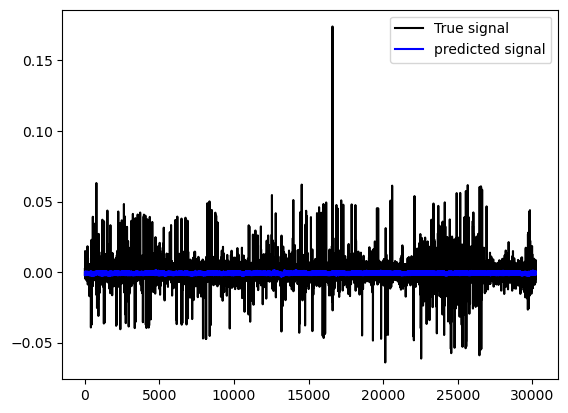

In [61]:
#Prediction plot
plt.plot(np.arange(len(X_test)), Y_test, color="black",label='True signal')
plt.plot(np.arange(len(X_test)), Y_pred, color="blue",label='predicted signal');
plt.legend();

#### B. Time series based models
##### LSTM

> RNN 
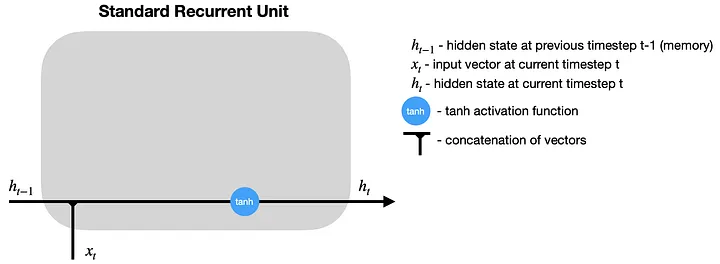

>LSTM

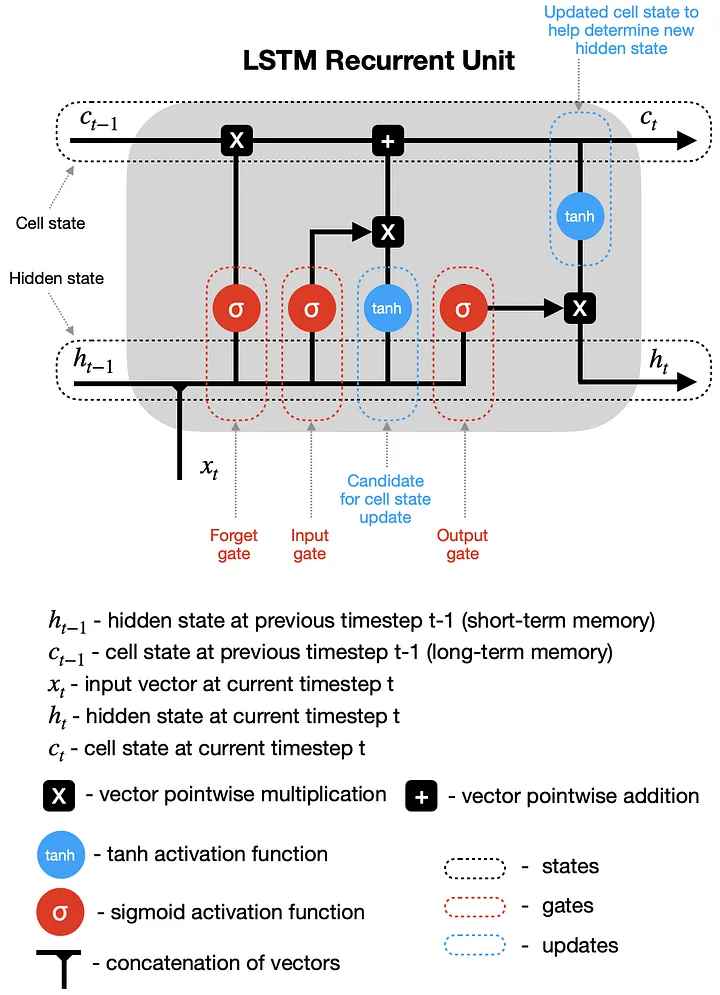

refernece :https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e

In [62]:
from torch.utils.data import Dataset,DataLoader
#Create dataset and dataloader with sequence to input for LSTM
class timeseries(Dataset):
    '''
    Time series dataset class which takes in our X and Y and produces a sequence of 15 previous datapoints (last 15 hour)
    if the there is not enough datapoints it pads the X and Y with the last valid observation
    '''
    def __init__(self,x,y,sequence_length=15):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(),dtype=torch.float32)
       
        self.len = x.shape[0]
        self.sequence_length=sequence_length

    def __getitem__(self, i): 
        #To create batch sequence input to lstm for x and y
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.x[i_start:(i + 1), :]
            y=self.y[i_start:(i + 1)]
        else:
            padding_x = self.x[0].repeat(self.sequence_length - i - 1, 1)
            padding_y=self.y[0].repeat(self.sequence_length - i - 1)
            x = self.x[0:(i + 1), :]
            y=self.y[0:(i + 1)]
            x = torch.cat((padding_x, x), 0)
            y=torch.cat((padding_y, y), 0)

        return x, y
  
    def __len__(self):
        return self.len

dataset_train = timeseries(X_train,Y_train,sequence_length=15)
dataset_val = timeseries(X_valid,Y_valid,sequence_length=15)
dataset_test = timeseries(X_test,Y_test,sequence_length=15)
#dataloader
 
train_loader = DataLoader(dataset_train,shuffle=False,batch_size=32)
val_loader = DataLoader(dataset_val,shuffle=False,batch_size=32)
test_loader=DataLoader(dataset_test,shuffle=False,batch_size=1)

In [63]:
#Simple LSTM model
class LSTMmodel(torch.nn.Module):
    '''
    Simple lstm followed by a fully connected layer
    All the weights and biases are initialized from U(-sqrt(k),sqrt(k)) where k=1/hidden_size
 
    '''
    def __init__(self,input_features,hidden_features,num_layers=1,drop_out=0):
        super(LSTMmodel, self).__init__()
        self.input_features=input_features#number of input features
        self.hidden_features=hidden_features# The number of features in the hidden state 
        self.num_layers=num_layers  #number of lstm layers
        self.drop_out=drop_out#specify dropout parameter
        self.lstm = nn.LSTM(input_size =self.input_features, hidden_size =self.hidden_features,num_layers =self.num_layers ,batch_first=True,dropout =self.drop_out) 
        self.linear = nn.Linear(self.hidden_features, 1)#fully connected layer to produce output 
        
        

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pred = self.linear(lstm_out)
        
        return pred

In [64]:
class EarlyStopper:
    '''
    Early stopping mechanism to stop learning if validation doesn't imporve by min_delta for a number of epochs
    called patience
    '''
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [80]:
def train_lstm(config):
    '''
    Function to train_lstm and validate as well takes as input the config for hyperparameter optimization
    '''
    epochs=10
    model=LSTMmodel(input_features=3,hidden_features=2,num_layers=config['NL'],drop_out=config['DO'])
    criterion = nn.MSELoss()#I use MSE loss 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['LR'])#use adam optimizer
    train_loss=[]#list of train losses
    val_loss=[]#list of validation losses
    early_stopper = EarlyStopper(patience=3, min_delta=0.0001)#early stopping 
    #check length of loader 
    for i in range(epochs):
        running_loss=0
        for step, (x, y) in enumerate(train_loader):

            y_pred = torch.squeeze(model.forward(x))
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_loss_epoch=running_loss/len(train_loader)
        train_loss.append(train_loss_epoch)
        #print('epoch',i,'training_loss',train_loss_epoch)
        
        running_val_loss=0
        with torch.no_grad(): 
               for step, (x, y) in enumerate(val_loader):
                    y_pred = torch.squeeze(model.forward(x))
                    loss = criterion(y_pred,y)
                    running_val_loss+=loss.item()
        val_loss_epoch=running_val_loss/len(val_loader)
        val_loss.append(val_loss_epoch)
        if(not(config['Out'])):
            tune.report(mse=val_loss_epoch)
        if(val_loss_epoch<=min(val_loss)):
            torch.save(model.state_dict(), 'best-model-parameters.pt')
        if early_stopper.early_stop(val_loss_epoch):
            #print('early stop')
            break
        

    #print('epoch',i,'val_loss',val_loss_epoch)
    if(config['Out']):
        return model

In [81]:
analysis = tune.run(
    train_lstm, config={"LR": tune.grid_search([0.000001, 0.001]),
                       "DO":tune.grid_search([0.1, 0.3]),
                       "NL":tune.grid_search([2, 4]),
                       "Out":False},metric="mse",mode='min',
                        )

2023-03-06 14:16:36,162	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mse,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_lstm_1f308_00000,2023-03-06_14-30-12,True,,a7387372bf35478287204ee8309c7042,"0_DO=0.1000,LR=0.0000,NL=2",youssefs-MacBook-Air.local,10,0.0114635,127.0.0.1,99046,811.325,60.4239,811.325,1678109412,0,,10,1f308_00000,0.00288677
train_lstm_1f308_00001,2023-03-06_14-27-13,True,,d1af454e221f419c929e030bf3fa5210,"1_DO=0.3000,LR=0.0000,NL=2",youssefs-MacBook-Air.local,7,0.00801787,127.0.0.1,99054,626.272,84.9365,626.272,1678109233,0,,7,1f308_00001,0.015239
train_lstm_1f308_00002,2023-03-06_14-24-23,True,,d895ebc0c7194b9a9c9a01b22de5ee36,"2_DO=0.1000,LR=0.0010,NL=2",youssefs-MacBook-Air.local,5,0.146285,127.0.0.1,99055,456.059,90.0795,456.059,1678109063,0,,5,1f308_00002,0.00904799
train_lstm_1f308_00003,2023-03-06_14-27-09,True,,56cede66f8b04ccdbb802ac40c4dca5c,"3_DO=0.3000,LR=0.0010,NL=2",youssefs-MacBook-Air.local,7,0.00985838,127.0.0.1,99056,621.956,85.6434,621.956,1678109229,0,,7,1f308_00003,0.0058639
train_lstm_1f308_00004,2023-03-06_14-37-44,True,,e173a83a007a4fda8b492d37c011c724,"4_DO=0.1000,LR=0.0000,NL=4",youssefs-MacBook-Air.local,10,0.0025027,127.0.0.1,99057,1256.73,91.9128,1256.73,1678109864,0,,10,1f308_00004,0.00781417
train_lstm_1f308_00005,2023-03-06_14-37-44,True,,f517a30a822944dfb3d0f52b4c0be98f,"5_DO=0.3000,LR=0.0000,NL=4",youssefs-MacBook-Air.local,10,0.0206702,127.0.0.1,99058,1257.14,91.8864,1257.14,1678109864,0,,10,1f308_00005,0.00423503
train_lstm_1f308_00006,2023-03-06_14-33-14,True,,3994669dfc78499fb8ce2b746271e677,"6_DO=0.1000,LR=0.0010,NL=4",youssefs-MacBook-Air.local,7,0.011962,127.0.0.1,99059,986.529,102.694,986.529,1678109594,0,,7,1f308_00006,0.0362999
train_lstm_1f308_00007,2023-03-06_14-27-46,True,,0459f9c467ed44f69be42b0ca15279aa,"7_DO=0.3000,LR=0.0010,NL=4",youssefs-MacBook-Air.local,4,0.0129949,127.0.0.1,99060,659.067,149.78,659.067,1678109266,0,,4,1f308_00007,0.00515413


2023-03-06 14:37:44,515	INFO tune.py:798 -- Total run time: 1268.47 seconds (1268.34 seconds for the tuning loop).


In [82]:
print("Best config: ", analysis.get_best_config(metric="mse",mode='min'))

Best config:  {'LR': 1e-06, 'DO': 0.1, 'NL': 4, 'Out': False}


In [83]:
#train with best config
config=analysis.get_best_config(metric="mse",mode='min')
config['Out']=True
model=train_lstm(config)

In [84]:
#predict on test set 
with torch.no_grad():
    y_out=[]
    y_pred_out=[]
    error=0
    corr=0
    for step, (x, y) in enumerate(test_loader):
        y_pred = torch.squeeze(model.forward(x))
        error+=torch.sum(y_pred-y)**2
        y_out.append(y.tolist()[0][-1])
        y_pred_out.append(y_pred.tolist()[-1])
    mse=error/len(test_loader)


In [85]:
print('MSE on test set:{}'.format(mse.item()))

MSE on test set:0.3142533600330353


In [118]:
np.shape(y_pred_out)

(30239,)

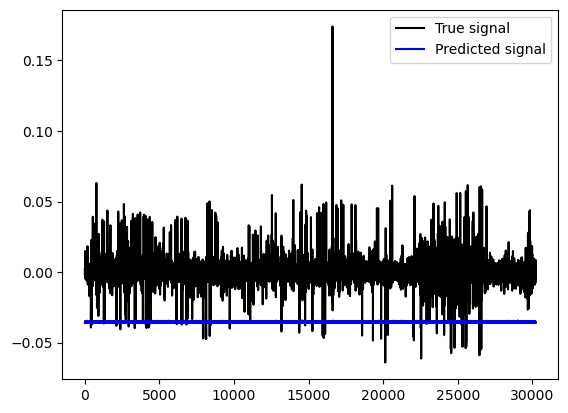

In [86]:
plt.plot(np.arange(len(y_out)), y_out, color="black",label='True signal')
plt.plot(np.arange(len(y_out)), y_pred_out, color="blue",label='Predicted signal');
plt.legend();

### State of the art model
#### Temporal Fuison transformer :Temporal Fusion Transformer (TFT) is a Transformer-based model that leverages self-attention to capture the complex temporal dynamics of multiple time sequences.


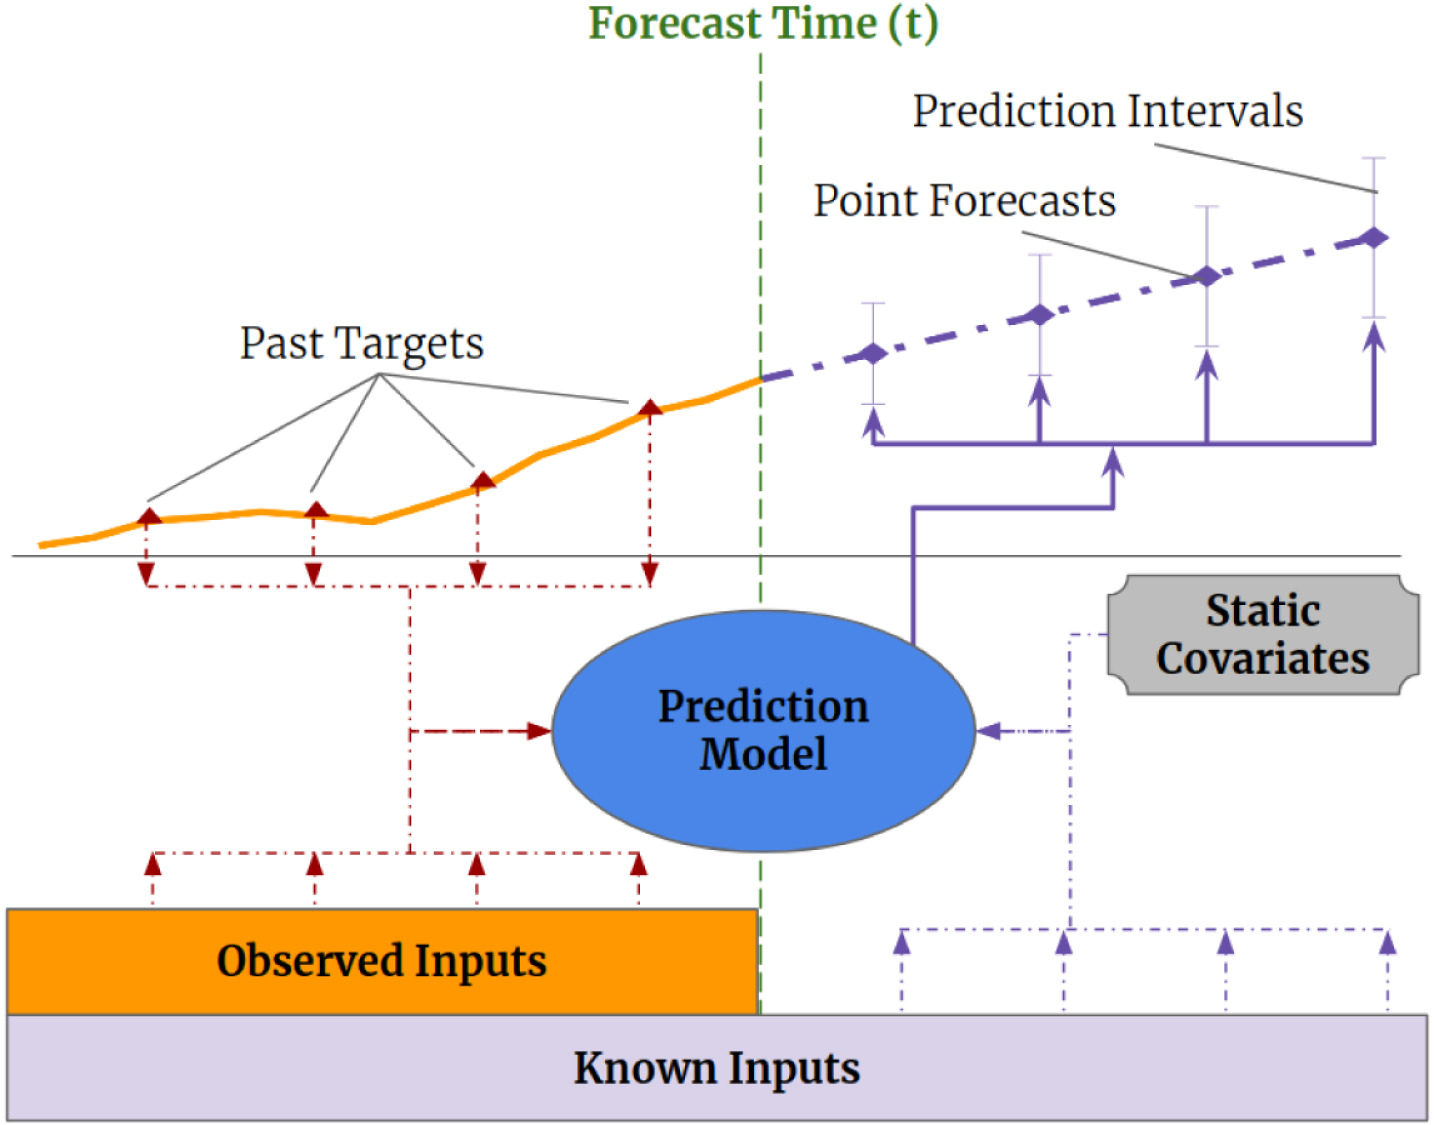
> Inputs model can work with

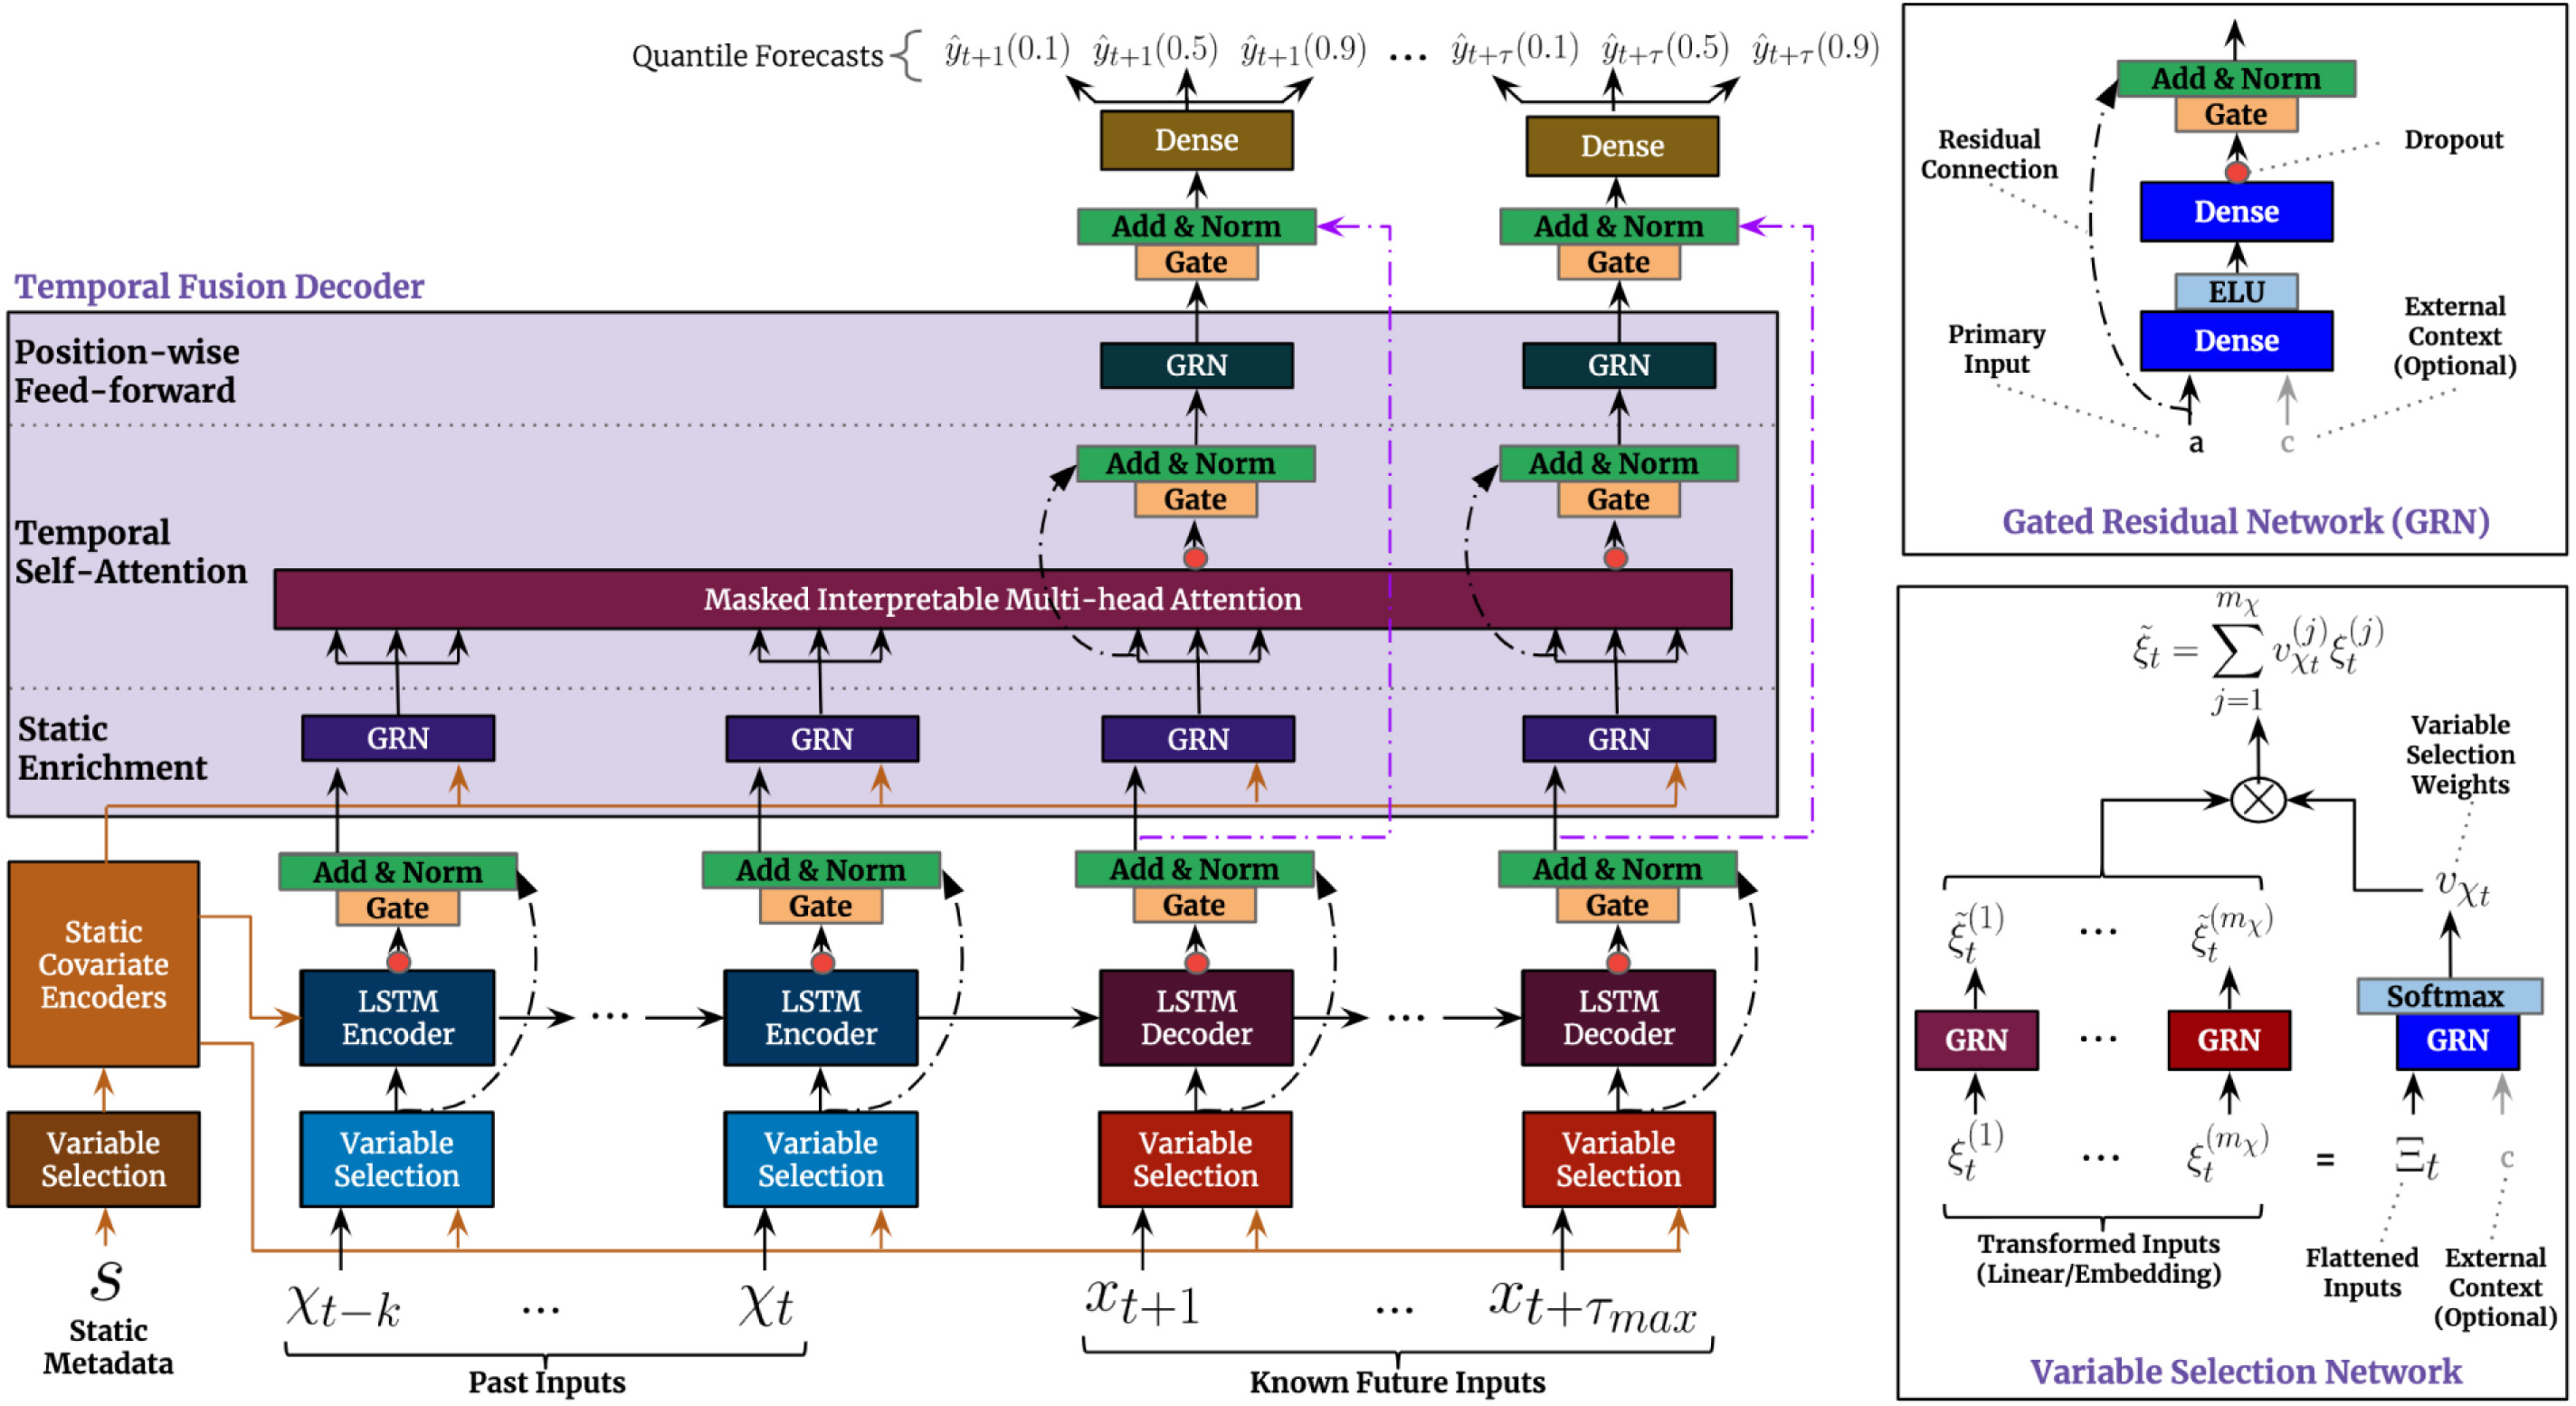
> Model architecture 

Reference :Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021). Temporal fusion transformers for interpretable multi-horizon time series forecasting. International Journal of Forecasting, 37(4), 1748-1764.

> Main features 
- gating mechanisms: skip over unused components of the model architecture
- variable selection networks: select relevant input variables at each time step.
- temporal processing of past and future input with LSTMs (long short-term memory)
- multi-head attention: captures long-term temporal dependencies
- prediction intervals: per default, produces quantile forecasts instead of deterministic values

In [87]:
#We need a timestep unit of an increase one in each index basically we calculate hours and use that 
df_train.reset_index(inplace=True)
df_train["timestamp"] = df_train["timestamp"]
df_train["time_idx"]=((df_train.timestamp/(60*60))).astype('int')

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/1888610158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["timestamp"] = df_train["timestamp"]
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/1888610158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["time_idx"]=((df_train.timestamp/(60*60))).astype('int')


In [88]:

df_valid.reset_index(inplace=True)
df_valid["timestamp"] = df_valid["timestamp"]
df_valid["time_idx"]=((df_valid.timestamp/(60*60))).astype('int')

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/4244872979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["timestamp"] = df_valid["timestamp"]
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/4244872979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["time_idx"]=((df_valid.timestamp/(60*60))).astype('int')


In [89]:
df_test.reset_index(inplace=True)
df_test["timestamp"] = df_test["timestamp"]
df_test["time_idx"]=((df_test.timestamp/(60*60))).astype('int')

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/1152990966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["timestamp"] = df_test["timestamp"]
/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/1152990966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["time_idx"]=((df_test.timestamp/(60*60))).astype('int')


In [138]:
max_prediction_length = 15#max prediction sequence
max_encoder_length = 15 #This is the maximum history length used by the time series dataset.
training = TimeSeriesDataSet(
    df_train,#data frame
    time_idx="time_idx",#incremental time index 
    target="Target",
    group_ids=["Asset_ID"],#every asset_ID is a different time series
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals =["Asset_ID"],#variables that don't change in time
    time_varying_known_reals=["timestamp"],#variables that change in time but are known in advance
    time_varying_unknown_reals=['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
           'Close_log', 'Open_log', 'High_log','Low_log', 'VWAP_log',
           'Close_ewp', 'Open_ewp', 'High_ewp', 'Low_ewp',
           'VWAP_ewp', 'Close_lag', 'Open_lag', 'High_lag', 
          'Low_lag', 'VWAP_lag','Target_lag'],#unkown variables in time 
    add_relative_time_idx=True,# variable to encode relative time index
    add_encoder_length=True,# variable to indicate where in the sequence are we 
)

In [139]:
validation =TimeSeriesDataSet(
    df_valid,
    time_idx="time_idx",
    target="Target",
    group_ids=["Asset_ID"],
     
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals =["Asset_ID"],
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
           'Close_log', 'Open_log', 'High_log','Low_log', 'VWAP_log',
           'Close_ewp', 'Open_ewp', 'High_ewp', 'Low_ewp',
           'VWAP_ewp', 'Close_lag', 'Open_lag', 'High_lag', 
          'Low_lag', 'VWAP_lag','Target_lag'],
    add_relative_time_idx=True,
    add_encoder_length=True,
)

In [140]:
test=TimeSeriesDataSet(
    df_test,
    time_idx="time_idx",
    target="Target",
    group_ids=["Asset_ID"],
    max_encoder_length=max_encoder_length,
     max_prediction_length=max_prediction_length,
    static_reals =["Asset_ID"],
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
           'Close_log', 'Open_log', 'High_log','Low_log', 'VWAP_log',
           'Close_ewp', 'Open_ewp', 'High_ewp', 'Low_ewp',
           'VWAP_ewp', 'Close_lag', 'Open_lag', 'High_lag', 
          'Low_lag', 'VWAP_lag','Target_lag'],
    add_relative_time_idx=True,
    add_encoder_length=True,
)
# create dataloaders for model
batch_size = 32  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size,num_workers=8)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size,num_workers=8)


In [141]:
pl.seed_everything(42)#random seed
trainer = pl.Trainer(gpus=0)
#early stopping mechanism 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=2, verbose=False, mode="min")

lr_logger = LearningRateMonitor()  # log the learning rate
trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    enable_model_summary=True,
    callbacks=[lr_logger, early_stop_callback],
   )


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0001,
    hidden_size=4,#hidden size of network 
    attention_head_size=1,#number of attention heads
    dropout=0.1,#drop out factor 
    hidden_continuous_size=4,#  hidden size for processing continous variables
    loss=QuantileLoss(),#default loss for tft
    reduce_on_plateau_patience=4,# patience after which learning rate is reduced by a factor of 10
    optimizer='adam'#usign adam optimizer 
)

Global seed set to 42
/Users/youssefmecky/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/youssefmecky/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/youssefmecky/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarn

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/youssefmecky/Desktop/Masters/ML2/Exam/g-research-crypto-forecasting/.lr_find_547eae2d-f3b3-4a70-9544-911c6f8cfe09.ckpt
Restored all states from the checkpoint file at /Users/youssefmecky/Desktop/Masters/ML2/Exam/g-research-crypto-forecasting/.lr_find_547eae2d-f3b3-4a70-9544-911c6f8cfe09.ckpt


suggested learning rate: 0.01862087136662867


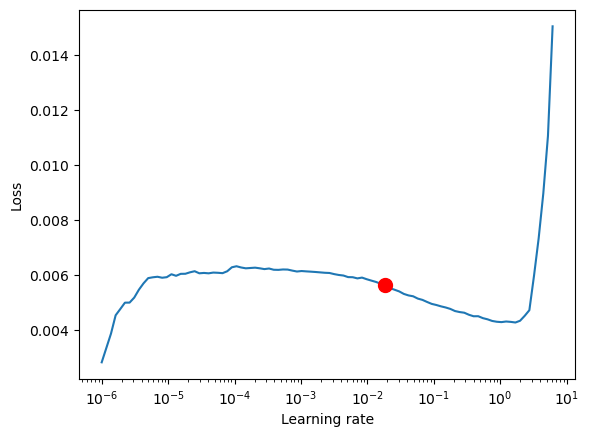

/var/folders/w4/_b3n8mvx2nx_86hmhz6jwnbm0000gn/T/ipykernel_92480/3782390496.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [142]:
#Use validation and training set to find optimal LR tests by default 100 lRs and it has an early stop thershold 
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()



In [143]:
new_lr = res.suggestion()

# update hparams of the model
tft.hparams.lr = new_lr

In [144]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 216   
4  | static_variable_selection          | VariableSelectionNetwork        | 238   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 246   
7  | static_context_variable_selection  | GatedResidualNetwork            | 88    
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 88    
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 88  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [145]:
#predictions
tft_pred=tft.predict(test_dataloader )
actuals = torch.cat([y for x, (y, weight) in iter(test_dataloader)])

In [146]:
#Mean squared error calculation 
mse=((actuals - tft_pred)**2).nanmean().item()
print('MSE on test set:{}'.format(mse))

MSE on test set:2.3956537916092202e-05


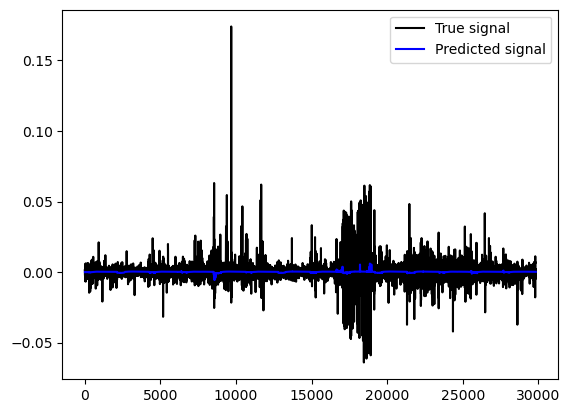

In [147]:
#Plot of prediction vs the true values
plt.plot(np.arange(len(actuals[:,-1])), actuals[:,-1], color="black",label='True signal')
plt.plot(np.arange(len(actuals[:,-1])), tft_pred[:,-1], color="blue",label='Predicted signal');
plt.legend();

### Conclusions 
> Linear regression model is actually not that bad in comparison to the other models given the complexity of the other models as it has the lowest MSE

> However from the visualiztions it looks like the tft is more able to capture the variations. 

>Maybe it is worth exploring simpler models for this problem something to captrue the star shape function we saw in the lag plot would be intreseting 

### Limitations and possible improvements 
> Use bayesian search instead of grid search

> Use full data set

> Optimitze hyper parameters in a wider scale 

> Use auto encoder as feature extracter 

> Look into the attention maps per variable for the tft to better understand what has been learned


### References
https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/  
https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3  
Htun, H.H., Biehl, M. & Petkov, N. Survey of feature selection and extraction techniques for stock market prediction. Financ Innov 9, 26 (2023). https://doi.org/10.1186/s40854-022-00441-7  
https://www.relataly.com/feature-engineering-for-multivariate-time-series-models-with-python/1813/  
https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda/notebook  
https://neptune.ai/blog/select-model-for-time-series-prediction-task  
https://builtin.com/data-science/time-series-model  
https://towardsdatascience.com/the-best-deep-learning-models-for-time-series-forecasting-690767bc63f0  
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html  
https://medium.com/analytics-vidhya/pytorch-for-deep-learning-lstm-for-sequence-data-d0708fdf5717  
https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch  
https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html  
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html  
Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021). Temporal fusion transformers for interpretable multi-horizon time series forecasting. International Journal of Forecasting, 37(4), 1748-1764.


### Thank you